In [7]:
!python3 -m pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/JonasGroeger/soundnode/pypi/simple
     |████████████████████████████████| 50.4 MB 50 kB/s s eta 0:00:01


In [1]:
# example of horizontal shift image augmentation

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from keras.utils import to_categorical
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout, Reshape
from keras.optimizers import SGD
import tensorflow as tf
import random as rng
import cv2

Using TensorFlow backend.


In [10]:
# Building the convolutional neural network

classifier = Sequential()

# Adding the first 2 convolution layer

classifier.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'))

classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(.7))

classifier.add(Conv2D(16, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(.7))

classifier.add(Conv2D(8, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(.7))

# Adding the flattening layer

classifier.add(Flatten())

# Adding the ANN

classifier.add(Dense(units=300, activation='relu'))
classifier.add(Dropout(rate=0.5))

classifier.add(Dense(units=150, activation='relu'))
classifier.add(Dropout(rate=0.5))
classifier.add(Dense(units=5, activation='softmax'))

from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.25, patience=2, min_lr=0.0001)
classifier.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy', metrics=['accuracy'])
classifier.summary()
# hist = classifier.fit_generator(train_it, 
#                          steps_per_epoch=1000,
#                          epochs=20,
#                          validation_data=(x_test,y_test),callbacks=[reduce_lr])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 16)        

In [2]:
#create image data augmentation generator
datagen = ImageDataGenerator(brightness_range=[0.5,1.0], 
                             zoom_range=[.85,.95],
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             fill_mode='constant',
                             cval=0,
                             validation_split=0.1)

(1000, 5) (1000, 28, 28, 1)


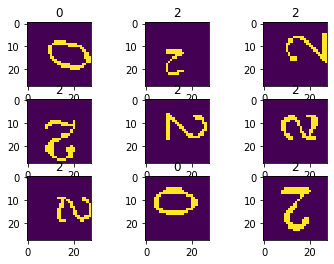

In [15]:
xx = []
yy = []

x_train, y_train = [], []
for j in range(1000):
    for i in range(5):
        pad = np.zeros((28, 28))
        fnt = rng.randint(0,7)
        scale = 1
        if fnt in [1, 5]:
            pass
        else:
            scale = 0.7
        pad = cv2.putText(pad, str(i), (7-rng.randint(-3,3),20-rng.randint(-3,3)), fnt,  
                        scale, 255, 1, cv2.LINE_AA)
        y_train.append(i)
        x_train.append(pad)
x_train = np.array(x_train).reshape(-1, 28, 28, 1)
y_train = to_categorical(np.array(y_train))
gen = datagen.flow(x_train, y_train, batch_size=1)

for i in range(1000):
    cur = gen.next()
    _x = cur[0].reshape(-1, 28, 28)
    _y = cur[1]
    xx.append(np.array([cv2.rotate(cv2.threshold(im.astype('uint8'), 10, 255, cv2.THRESH_OTSU)[1], 
                        rng.choice([0, cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE])) for im in _x ]))
    yy.append(_y)

x = np.asarray(xx)
x = x.reshape(-1, 28, 28, 1) / 255.
y = np.array(yy).reshape(-1, 5)

print(y.shape, x.shape)

# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    
    k = rng.randint(1, 1000)
  
    plt.imshow(x[k].reshape(28,28))
    plt.title(y[k].argmax())
# show the figure
plt.show()

In [38]:
from keras.callbacks import EarlyStopping
history = classifier.fit(x, y, epochs=600, batch_size=32, callbacks=[reduce_lr], validation_split=0.2)

# plt.imshow(x[0].reshape(28,28))
classifier.save("digits_shitty_model.h5")
classifier.evaluate(x, y)

Train on 800 samples, validate on 200 samples
Epoch 1/600
800/800 [==============================] - 0s 270us/step - loss: 0.5354 - accuracy: 0.8188 - val_loss: 2.1856 - val_accuracy: 0.1800
Epoch 2/600
800/800 [==============================] - 0s 284us/step - loss: 0.5242 - accuracy: 0.8225 - val_loss: 2.2025 - val_accuracy: 0.1800
Epoch 3/600
800/800 [==============================] - 0s 291us/step - loss: 0.5363 - accuracy: 0.8400 - val_loss: 2.3026 - val_accuracy: 0.1750
Epoch 4/600
800/800 [==============================] - 0s 298us/step - loss: 0.5112 - accuracy: 0.8188 - val_loss: 2.1644 - val_accuracy: 0.1800
Epoch 5/600
800/800 [==============================] - 0s 288us/step - loss: 0.5688 - accuracy: 0.8263 - val_loss: 2.2902 - val_accuracy: 0.1800
Epoch 6/600
800/800 [==============================] - 0s 293us/step - loss: 0.5694 - accuracy: 0.8163 - val_loss: 2.1498 - val_accuracy: 0.1800
Epoch 7/600
800/800 [==============================] - 0s 259us/step - loss: 0.5595 

Epoch 57/600
800/800 [==============================] - 0s 289us/step - loss: 0.5177 - accuracy: 0.8338 - val_loss: 2.0070 - val_accuracy: 0.1950
Epoch 58/600
800/800 [==============================] - 0s 279us/step - loss: 0.5021 - accuracy: 0.8263 - val_loss: 1.9562 - val_accuracy: 0.2150
Epoch 59/600
800/800 [==============================] - 0s 257us/step - loss: 0.5063 - accuracy: 0.8375 - val_loss: 2.0459 - val_accuracy: 0.1950
Epoch 60/600
800/800 [==============================] - 0s 276us/step - loss: 0.4955 - accuracy: 0.8413 - val_loss: 1.9788 - val_accuracy: 0.2050
Epoch 61/600
800/800 [==============================] - 0s 258us/step - loss: 0.5172 - accuracy: 0.8263 - val_loss: 1.9200 - val_accuracy: 0.2450
Epoch 62/600
800/800 [==============================] - 0s 267us/step - loss: 0.5392 - accuracy: 0.8263 - val_loss: 2.0394 - val_accuracy: 0.2100
Epoch 63/600
800/800 [==============================] - 0s 303us/step - loss: 0.5031 - accuracy: 0.8388 - val_loss: 2.0962 -

800/800 [==============================] - 0s 276us/step - loss: 0.5601 - accuracy: 0.8188 - val_loss: 1.9546 - val_accuracy: 0.2250
Epoch 114/600
800/800 [==============================] - 0s 296us/step - loss: 0.4803 - accuracy: 0.8425 - val_loss: 1.9629 - val_accuracy: 0.2600
Epoch 115/600
800/800 [==============================] - 0s 269us/step - loss: 0.4625 - accuracy: 0.8512 - val_loss: 2.0361 - val_accuracy: 0.2200
Epoch 116/600
800/800 [==============================] - 0s 307us/step - loss: 0.4993 - accuracy: 0.8375 - val_loss: 1.9570 - val_accuracy: 0.2750
Epoch 117/600
800/800 [==============================] - 0s 296us/step - loss: 0.5046 - accuracy: 0.8263 - val_loss: 2.0355 - val_accuracy: 0.2450
Epoch 118/600
800/800 [==============================] - 0s 281us/step - loss: 0.4863 - accuracy: 0.8300 - val_loss: 2.0094 - val_accuracy: 0.2350
Epoch 119/600
800/800 [==============================] - 0s 285us/step - loss: 0.4832 - accuracy: 0.8475 - val_loss: 2.1543 - val_ac

Epoch 169/600
800/800 [==============================] - 0s 285us/step - loss: 0.4429 - accuracy: 0.8662 - val_loss: 2.1470 - val_accuracy: 0.1850
Epoch 170/600
800/800 [==============================] - 0s 296us/step - loss: 0.4554 - accuracy: 0.8625 - val_loss: 2.2502 - val_accuracy: 0.1750
Epoch 171/600
800/800 [==============================] - 0s 293us/step - loss: 0.5138 - accuracy: 0.8338 - val_loss: 2.3025 - val_accuracy: 0.1750
Epoch 172/600
800/800 [==============================] - 0s 286us/step - loss: 0.5731 - accuracy: 0.8062 - val_loss: 2.1902 - val_accuracy: 0.1900
Epoch 173/600
800/800 [==============================] - 0s 271us/step - loss: 0.5020 - accuracy: 0.8138 - val_loss: 2.0848 - val_accuracy: 0.2000
Epoch 174/600
800/800 [==============================] - 0s 285us/step - loss: 0.5168 - accuracy: 0.8375 - val_loss: 2.1513 - val_accuracy: 0.1950
Epoch 175/600
800/800 [==============================] - 0s 273us/step - loss: 0.4658 - accuracy: 0.8612 - val_loss: 2

Epoch 225/600
800/800 [==============================] - 0s 285us/step - loss: 0.4856 - accuracy: 0.8375 - val_loss: 2.1801 - val_accuracy: 0.1900
Epoch 226/600
800/800 [==============================] - 0s 290us/step - loss: 0.4883 - accuracy: 0.8450 - val_loss: 2.1401 - val_accuracy: 0.1950
Epoch 227/600
800/800 [==============================] - 0s 272us/step - loss: 0.4226 - accuracy: 0.8662 - val_loss: 2.0948 - val_accuracy: 0.2100
Epoch 228/600
800/800 [==============================] - 0s 292us/step - loss: 0.4911 - accuracy: 0.8450 - val_loss: 2.1934 - val_accuracy: 0.1850
Epoch 229/600
800/800 [==============================] - 0s 300us/step - loss: 0.4636 - accuracy: 0.8612 - val_loss: 2.2007 - val_accuracy: 0.1850
Epoch 230/600
800/800 [==============================] - 0s 283us/step - loss: 0.5172 - accuracy: 0.8288 - val_loss: 2.1366 - val_accuracy: 0.1900
Epoch 231/600
800/800 [==============================] - 0s 289us/step - loss: 0.4521 - accuracy: 0.8487 - val_loss: 2

Epoch 281/600
800/800 [==============================] - 0s 285us/step - loss: 0.5149 - accuracy: 0.8388 - val_loss: 2.2403 - val_accuracy: 0.2050
Epoch 282/600
800/800 [==============================] - 0s 290us/step - loss: 0.4691 - accuracy: 0.8487 - val_loss: 2.3066 - val_accuracy: 0.1950
Epoch 283/600
800/800 [==============================] - 0s 295us/step - loss: 0.4367 - accuracy: 0.8587 - val_loss: 2.2292 - val_accuracy: 0.1950
Epoch 284/600
800/800 [==============================] - 0s 283us/step - loss: 0.4440 - accuracy: 0.8587 - val_loss: 2.1443 - val_accuracy: 0.2100
Epoch 285/600
800/800 [==============================] - 0s 288us/step - loss: 0.4796 - accuracy: 0.8487 - val_loss: 2.2603 - val_accuracy: 0.2000
Epoch 286/600
800/800 [==============================] - 0s 276us/step - loss: 0.4522 - accuracy: 0.8475 - val_loss: 2.1932 - val_accuracy: 0.2000
Epoch 287/600
800/800 [==============================] - 0s 284us/step - loss: 0.4863 - accuracy: 0.8388 - val_loss: 1

Epoch 337/600
800/800 [==============================] - 0s 276us/step - loss: 0.4497 - accuracy: 0.8500 - val_loss: 2.2564 - val_accuracy: 0.1800
Epoch 338/600
800/800 [==============================] - 0s 266us/step - loss: 0.4753 - accuracy: 0.8525 - val_loss: 2.2585 - val_accuracy: 0.1950
Epoch 339/600
800/800 [==============================] - 0s 285us/step - loss: 0.4103 - accuracy: 0.8537 - val_loss: 2.1831 - val_accuracy: 0.1900
Epoch 340/600
800/800 [==============================] - 0s 269us/step - loss: 0.4680 - accuracy: 0.8400 - val_loss: 2.3173 - val_accuracy: 0.1850
Epoch 341/600
800/800 [==============================] - 0s 288us/step - loss: 0.4520 - accuracy: 0.8562 - val_loss: 2.5065 - val_accuracy: 0.1850
Epoch 342/600
800/800 [==============================] - 0s 289us/step - loss: 0.4686 - accuracy: 0.8450 - val_loss: 2.4365 - val_accuracy: 0.1850
Epoch 343/600
800/800 [==============================] - 0s 284us/step - loss: 0.4802 - accuracy: 0.8413 - val_loss: 2

Epoch 393/600
800/800 [==============================] - 0s 292us/step - loss: 0.4348 - accuracy: 0.8575 - val_loss: 2.2423 - val_accuracy: 0.1950
Epoch 394/600
800/800 [==============================] - 0s 273us/step - loss: 0.4419 - accuracy: 0.8512 - val_loss: 2.2387 - val_accuracy: 0.1900
Epoch 395/600
800/800 [==============================] - 0s 302us/step - loss: 0.4325 - accuracy: 0.8512 - val_loss: 2.3330 - val_accuracy: 0.1950
Epoch 396/600
800/800 [==============================] - 0s 295us/step - loss: 0.4822 - accuracy: 0.8388 - val_loss: 2.4373 - val_accuracy: 0.1950
Epoch 397/600
800/800 [==============================] - 0s 281us/step - loss: 0.4370 - accuracy: 0.8537 - val_loss: 2.4855 - val_accuracy: 0.1950
Epoch 398/600
800/800 [==============================] - 0s 289us/step - loss: 0.4419 - accuracy: 0.8575 - val_loss: 2.3319 - val_accuracy: 0.1900
Epoch 399/600
800/800 [==============================] - 0s 285us/step - loss: 0.4919 - accuracy: 0.8325 - val_loss: 2

Epoch 449/600
800/800 [==============================] - 0s 300us/step - loss: 0.4243 - accuracy: 0.8575 - val_loss: 2.0896 - val_accuracy: 0.2550
Epoch 450/600
800/800 [==============================] - 0s 256us/step - loss: 0.4633 - accuracy: 0.8600 - val_loss: 2.3332 - val_accuracy: 0.2200
Epoch 451/600
800/800 [==============================] - 0s 279us/step - loss: 0.4362 - accuracy: 0.8587 - val_loss: 2.2478 - val_accuracy: 0.2650
Epoch 452/600
800/800 [==============================] - 0s 277us/step - loss: 0.3861 - accuracy: 0.8775 - val_loss: 2.4468 - val_accuracy: 0.1950
Epoch 453/600
800/800 [==============================] - 0s 281us/step - loss: 0.4049 - accuracy: 0.8725 - val_loss: 2.4038 - val_accuracy: 0.2050
Epoch 454/600
800/800 [==============================] - 0s 285us/step - loss: 0.4036 - accuracy: 0.8700 - val_loss: 2.3168 - val_accuracy: 0.2150
Epoch 455/600
800/800 [==============================] - 0s 258us/step - loss: 0.4514 - accuracy: 0.8450 - val_loss: 2

Epoch 505/600
800/800 [==============================] - 0s 286us/step - loss: 0.4757 - accuracy: 0.8313 - val_loss: 2.2929 - val_accuracy: 0.2000
Epoch 506/600
800/800 [==============================] - 0s 289us/step - loss: 0.4503 - accuracy: 0.8587 - val_loss: 2.5650 - val_accuracy: 0.1800
Epoch 507/600
800/800 [==============================] - 0s 299us/step - loss: 0.3952 - accuracy: 0.8562 - val_loss: 2.4413 - val_accuracy: 0.1950
Epoch 508/600
800/800 [==============================] - 0s 293us/step - loss: 0.4407 - accuracy: 0.8450 - val_loss: 2.4424 - val_accuracy: 0.1900
Epoch 509/600
800/800 [==============================] - 0s 289us/step - loss: 0.4249 - accuracy: 0.8637 - val_loss: 2.5920 - val_accuracy: 0.1800
Epoch 510/600
800/800 [==============================] - 0s 285us/step - loss: 0.3945 - accuracy: 0.8788 - val_loss: 2.4810 - val_accuracy: 0.1900
Epoch 511/600
800/800 [==============================] - 0s 271us/step - loss: 0.4073 - accuracy: 0.8687 - val_loss: 2

Epoch 561/600
800/800 [==============================] - 0s 299us/step - loss: 0.4057 - accuracy: 0.8662 - val_loss: 2.4752 - val_accuracy: 0.1950
Epoch 562/600
800/800 [==============================] - 0s 290us/step - loss: 0.3730 - accuracy: 0.8800 - val_loss: 2.3217 - val_accuracy: 0.2300
Epoch 563/600
800/800 [==============================] - 0s 308us/step - loss: 0.4247 - accuracy: 0.8625 - val_loss: 2.3718 - val_accuracy: 0.1950
Epoch 564/600
800/800 [==============================] - 0s 276us/step - loss: 0.4274 - accuracy: 0.8575 - val_loss: 2.4200 - val_accuracy: 0.1950
Epoch 565/600
800/800 [==============================] - 0s 278us/step - loss: 0.4061 - accuracy: 0.8675 - val_loss: 2.6386 - val_accuracy: 0.1900
Epoch 566/600
800/800 [==============================] - 0s 289us/step - loss: 0.4554 - accuracy: 0.8450 - val_loss: 2.2181 - val_accuracy: 0.2150
Epoch 567/600
800/800 [==============================] - 0s 273us/step - loss: 0.4185 - accuracy: 0.8512 - val_loss: 2

KeyboardInterrupt: 

In [32]:
y_train.shape

(4000, 4)

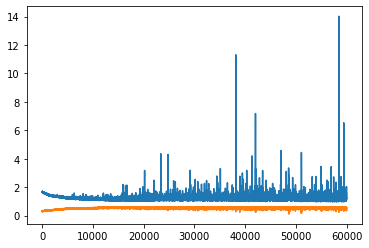

In [27]:
plt.plot(history.__dict__['history']['loss'])
plt.plot(history.__dict__['history']['accuracy'])
# plt.plot(history.__dict__['history']['lr'])

In [8]:
'''
Trains a GDenseNet-40-12 model on the CIFAR-10 Dataset.
'''
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras_gcnn.applications.densenetnew import GDenseNet

batch_size = 16
nb_classes = 5
epochs = 100

img_rows, img_cols = 28, 28
img_channels = 1

# Parameters for the DenseNet model builder
img_dim = (img_channels, img_rows, img_cols) if K.image_data_format() == 'channels_first' else (
    img_rows, img_cols, img_channels)
depth = 10
nb_dense_block = 3
growth_rate = 3  # number of z2 maps equals growth_rate * group_size, so keep this small.
nb_filter = 16
dropout_rate = 0.4  # 0.0 for data augmentation
conv_group = 'C4'  # C4 includes 90 degree rotations, D4 additionally includes reflections in x and y axis.
use_gcnn = True

In [11]:
# Create the model (without loading weights)
model = GDenseNet(mc_dropout=False, padding='same', nb_dense_block=nb_dense_block, growth_rate=growth_rate,
                  nb_filter=nb_filter, dropout_rate=dropout_rate, weights=None, input_shape=img_dim, depth=depth,
                  use_gcnn=use_gcnn, conv_group=conv_group, classes=nb_classes)
print('Model created')

model.summary()

optimizer = Adam(lr=1e-3)  # Using Adam instead of SGD to speed up training
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
print('Finished compiling')

nb_layers computed: [2, 2, 2] 2
Model created
Model: "densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
initial_Gconv2D (GConv2D)       (None, 28, 28, 64)   144         input_3[0][0]                    
__________________________________________________________________________________________________
dense_0_0_bn (GBatchNorm)       (None, 28, 28, 64)   64          initial_Gconv2D[0][0]            
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 28, 28, 64)   0           dense_0_0_bn[0][0]               
_____________________________________________

In [14]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1),
                               cooldown=0, patience=10, min_lr=0.5e-6)
# early_stopper = EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=20)
model_checkpoint = ModelCheckpoint('checkpt_digits', monitor='val_acc', save_best_only=True,
                                   save_weights_only=True, mode='auto')

callbacks = [lr_reducer, model_checkpoint]

history = model.fit(x, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=callbacks)

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 1s 748us/step - loss: 0.1837 - acc: 0.9925 - val_loss: 0.8429 - val_acc: 0.6450
Epoch 2/100
800/800 [==============================] - 1s 755us/step - loss: 0.1825 - acc: 0.9900 - val_loss: 0.8315 - val_acc: 0.6850
Epoch 3/100
800/800 [==============================] - 1s 732us/step - loss: 0.1957 - acc: 0.9900 - val_loss: 0.8616 - val_acc: 0.6800
Epoch 4/100
800/800 [==============================] - 1s 738us/step - loss: 0.1811 - acc: 0.9987 - val_loss: 0.6525 - val_acc: 0.7550
Epoch 5/100
800/800 [==============================] - 1s 728us/step - loss: 0.1803 - acc: 0.9925 - val_loss: 0.6036 - val_acc: 0.7800
Epoch 6/100
800/800 [==============================] - 1s 752us/step - loss: 0.1809 - acc: 0.9937 - val_loss: 0.5529 - val_acc: 0.7800
Epoch 7/100
800/800 [==============================] - 1s 746us/step - loss: 0.1819 - acc: 0.9925 - val_loss: 0.5748 - val_acc: 0.8050
Epoch 8/1

Epoch 61/100
800/800 [==============================] - 1s 743us/step - loss: 0.1604 - acc: 0.9950 - val_loss: 0.8318 - val_acc: 0.6800
Epoch 62/100
800/800 [==============================] - 1s 745us/step - loss: 0.1767 - acc: 0.9912 - val_loss: 0.8354 - val_acc: 0.6800
Epoch 63/100
800/800 [==============================] - 1s 751us/step - loss: 0.1686 - acc: 0.9950 - val_loss: 0.8339 - val_acc: 0.6750
Epoch 64/100
800/800 [==============================] - 1s 763us/step - loss: 0.1679 - acc: 0.9925 - val_loss: 0.8391 - val_acc: 0.6750
Epoch 65/100
800/800 [==============================] - 1s 745us/step - loss: 0.1629 - acc: 0.9975 - val_loss: 0.8366 - val_acc: 0.6750
Epoch 66/100
800/800 [==============================] - 1s 744us/step - loss: 0.1655 - acc: 0.9950 - val_loss: 0.8316 - val_acc: 0.6800
Epoch 67/100
800/800 [==============================] - 1s 755us/step - loss: 0.1736 - acc: 0.9975 - val_loss: 0.8251 - val_acc: 0.6850
Epoch 68/100
800/800 [==========================

In [16]:
model.evaluate(x,y)

1000/1000 [==============================] - 0s 226us/step


[1.0213440084457397, 0.621999979019165]

4

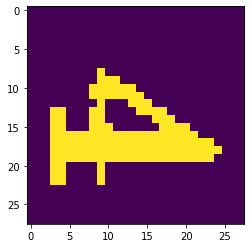

In [27]:
img = cv2.imread("/home/kivicode/Downloads/4.png", cv2.IMREAD_GRAYSCALE)
img = 255 - cv2.rotate(cv2.threshold(img, 10, 255, cv2.THRESH_OTSU)[1], rng.choice([0, cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE]))
plt.imshow(img)

img = img.reshape(-1, 28, 28, 1) / 255.
model.predict(img).argmax()

In [28]:
model.save("digits_0-4_model.h5")

In [31]:
help(GDenseNet)

Help on function GDenseNet in module keras_gcnn.applications.densenetnew:

GDenseNet(mc_dropout, padding, nb_dense_block=3, growth_rate=12, nb_filter=-1, nb_layers_per_block=-1, bottleneck=False, reduction=0.0, dropout_rate=0.0, weight_decay=0.0001, subsample_initial_block=False, include_top=True, weights=None, input_tensor=None, pooling=None, classes=10, activation='softmax', input_shape=None, depth=40, bn_momentum=0.99, use_gcnn=False, conv_group=None, depth_multiplier=1, use_g_bn=True, kernel_size=3, mc_bn=None)
    Instantiate the DenseNet architecture.
    
    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.
    
    # Arguments
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` dim ordering)
            or `(